In [1]:
import os
import glob

import radio
from radio.batchflow import FilesIndex, Dataset, Pipeline
from radio import CTImagesMaskedBatch as CTIMB
from radio import batchflow as bf
import utils
import warnings
warnings.filterwarnings("ignore")

ModuleNotFoundError: No module named 'radio'

In [21]:
# plot a scan and a corresponding mask
PATH_TO_FOLDER = "/home/paul/Projects/LIDC-IDRI/LIDC-IDRI-0001/01-01-2000-30178/3000566-03192/"
# PATH_TO_FOLDER = "./data/05dzgcM/"
# path_to_scans_sample = glob.glob(PATH_TO_FOLDER + '*.nii.gz', recursive=True)
path_to_scans_sample = glob.glob(PATH_TO_FOLDER + '*.dcm', recursive=True)
# print(path_to_scans_sample)
# ct_index = FilesIndex(path=path_to_scans_sample, no_ext=True)
ct_index = FilesIndex(path=PATH_TO_FOLDER, dirs=True)
dataset = bf.Dataset(index=ct_index, batch_class=CTIMB)
print(len(dataset.indices))

1


In [22]:
SPACING = (1.0, 1.0, 1.0)  # spacing of scans after spacing unification
SHAPE = (328, 364, 364)  # shape of scans after spacing unification
PADDING = 'reflect'  # 'reflect' padding-mode produces the least amount of artefacts
METHOD = 'pil-simd'  # robust resize-engine

preprocessing = (Pipeline()
                .load(fmt='dicom', components=['images', 'spacing', 'origin']))
#                 .resize(shape=SHAPE))
#                 .unify_spacing(spacing=(1.,1.,1.), shape=(328,364,364), method=METHOD, padding='reflect'))

In [23]:
batch = (dataset >> preprocessing).next_batch(1)

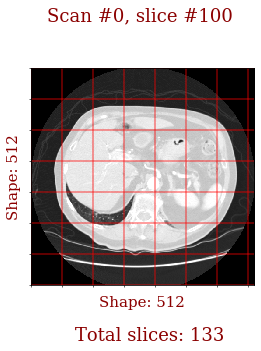

In [24]:
utils.show_slices(batch, scan_indices=[0], ns_slice=[100], grid=True, clims=(-1200, 200))

In [17]:
batch.spacing

array([[-0.71093798, -0.71093798,  2.5       ]])

In [63]:
import logging
import xml.etree.ElementTree as etree
import numpy as np

from nodule_structs import RadAnnotation, SmallNodule, NormalNodule, \
    NoduleRoi, NonNodule, AnnotationHeader

FOLDER = '/home/paul/Projects/LIDC-IDRI/LIDC-IDRI-0001/'
NS = {'nih': 'http://www.nih.gov'}

def parse_dir(dirname, flatten=True, pickle=True):
    assert os.path.isdir(dirname)

    if not flatten:
        return parse_original_xmls(dirname, pickle)

    pickle_file = os.path.join(dirname, 'annotation_flatten.pkl')
    if os.path.isfile(pickle_file):
        logging.info("Loading annotations from file %s" % pickle_file)
        with open(pickle_file, 'r') as f:
            annotations = cPickle.load(f)
        logging.info("Load annotations complete")
        return annotations
    annotations = parse_original_xmls(dirname, pickle)
    annotations = flatten_annotation(annotations)
    if pickle:
        logging.info("Saving annotations to file %s" % pickle_file)
        print(annotations)
#         with open(pickle_file, 'w') as f:
#             cPickle.dump(annotations, f)
    return annotations

def parse_original_xmls(dirname, pickle=True):
    pickle_file = pickle and os.path.join(dirname, 'annotation.pkl') or None
    if pickle and os.path.isfile(pickle_file):
        logging.info("Loading annotations from file %s" % pickle_file)
        with open(pickle_file, 'r') as f:
            annotations = cPickle.load(f)
        logging.info("Load annotations complete")
    else:
        logging.info("Reading annotations")
        annotations = []
        xml_files = find_all_files(dirname, '.xml')
        for f in xml_files:
            annotations.append(parse(f))
    if pickle and not os.path.isfile(pickle_file):
        logging.info("Saving annotations to file %s" % pickle_file)
#         with open(pickle_file, 'w') as f:
#             cPickle.dump(annotations, f)
    return annotations

def find_all_files(root, suffix=None):
    res = []
    for root, _, files in os.walk(root):
        for f in files:
            if suffix is not None and not f.endswith(suffix):
                continue
            res.append(os.path.join(root, f))
    return res

def flatten_annotation(annotation_dict):
    logging.info("Start flatten")
    res = {}
    for annotations in annotation_dict:
        # annotations in each file
        for anno in annotations:
            flatten_nodule(anno.nodules, 'nodules', res)
            flatten_nodule(anno.small_nodules, 'small_nodules', res)
            flatten_nodule(anno.non_nodules, 'non_nodules', res)
    logging.info("Flatten complete")
    return res

def parse(xml_filename):
    logging.info("Parsing %s" % xml_filename)
    annotations = []
    # ET is the library we use to parse xml data
    tree = etree.parse(xml_filename)
    root = tree.getroot()
    header = parse_header(root)
#     readingSession-> holds radiologist's annotation info
    for read_session in root.findall('nih:readingSession', NS):
        # to hold each radiologists annotation
        # i.e. readingSession in xml file
        rad_annotation = RadAnnotation()
        rad_annotation.version = \
            read_session.find('nih:annotationVersion', NS).text
        rad_annotation.id = \
            read_session.find('nih:servicingRadiologistID', NS).text

        # nodules
        nodule_nodes = read_session.findall('nih:unblindedReadNodule', NS)
        for node in nodule_nodes:
            nodule = parse_nodule(node)
            if nodule.is_small:
                rad_annotation.small_nodules.append(nodule)
            else:
                rad_annotation.nodules.append(nodule)

        # non-nodules
        non_nodule = read_session.findall('nih:nonNodule', NS)
        for node in non_nodule:
            nodule = parse_non_nodule(node)
            rad_annotation.non_nodules.append(nodule)
        
#         print(rad_annotation)
        annotations.append(rad_annotation)
    return annotations


def parse_header(root):
    header = AnnotationHeader()
    try:
        element = {'nih': 'http://www.nih.gov'}
        resp_hdr = root.findall('nih:ResponseHeader', element)[0]
    except IndexError:
        element = {'nih': 'http://www.nih.gov/idri'}
        resp_hdr = root.findall('nih:ResponseHeader', element)[0]
    header.version = resp_hdr.find('nih:Version', element).text
    header.message_id = resp_hdr.find('nih:MessageId', element).text
    header.date_request = resp_hdr.find('nih:DateRequest', element).text
    header.time_request = resp_hdr.find('nih:TimeRequest', element).text
    header.task_desc = resp_hdr.find('nih:TaskDescription', element).text
    header.series_instance_uid = resp_hdr.find('nih:SeriesInstanceUid', element).text
    date_service = resp_hdr.find('nih:DateService', element)
    if date_service is not None:
        header.date_service = date_service.text
    time_service = resp_hdr.find('nih:TimeService', element)
    if time_service is not None:
        header.time_service = time_service.text
    header.study_instance_uid = resp_hdr.find('nih:StudyInstanceUID', element).text
    return header


def parse_nodule(xml_node):  # xml_node is one unblindedReadNodule
    char_node = xml_node.find('nih:characteristics', NS)
    # if no characteristics, it is smallnodule  i.e. is_small=TRUE
    is_small = (char_node is None or len(char_node) == 0)
    nodule = is_small and SmallNodule() or NormalNodule()
    nodule.id = xml_node.find('nih:noduleID', NS).text
    if not is_small:
        subtlety = char_node.find('nih:subtlety', NS)
        nodule.characteristics.subtlety = int(subtlety.text)
        nodule.characteristics.internal_struct = \
            int(char_node.find('nih:internalStructure', NS).text)
        nodule.characteristics.calcification = \
            int(char_node.find('nih:calcification', NS).text)
        nodule.characteristics.sphericity = \
            int(char_node.find('nih:sphericity', NS).text)
        nodule.characteristics.margin = \
            int(char_node.find('nih:margin', NS).text)
        nodule.characteristics.lobulation = \
            int(char_node.find('nih:lobulation', NS).text)
        nodule.characteristics.spiculation = \
            int(char_node.find('nih:spiculation', NS).text)
        nodule.characteristics.texture = \
            int(char_node.find('nih:texture', NS).text)
        nodule.characteristics.malignancy = \
            int(char_node.find('nih:malignancy', NS).text)
    xml_rois = xml_node.findall('nih:roi', NS)
    for xml_roi in xml_rois:
        roi = NoduleRoi()
        roi.z = float(xml_roi.find('nih:imageZposition', NS).text)
        roi.sop_uid = xml_roi.find('nih:imageSOP_UID', NS).text
        # when inclusion = TRUE ->roi includes the whole nodule
        # when inclusion = FALSE ->roi is drown twice for one nodule
        # 1.ouside the nodule
        # 2.inside the nodule -> to indicate that the nodule has donut
        # hole(the inside hole is
        # not part of the nodule) but by forcing inclusion to be TRUE,
        # this situation is ignored
        roi.inclusion = (xml_roi.find('nih:inclusion', NS).text == "TRUE")
        edge_maps = xml_roi.findall('nih:edgeMap', NS)
        for edge_map in edge_maps:
            x = int(edge_map.find('nih:xCoord', NS).text)
            y = int(edge_map.find('nih:yCoord', NS).text)
            roi.roi_xy.append([x, y])
        xmax = np.array(roi.roi_xy)[:, 0].max()
        xmin = np.array(roi.roi_xy)[:, 0].min()
        ymax = np.array(roi.roi_xy)[:, 1].max()
        ymin = np.array(roi.roi_xy)[:, 1].min()
        if not is_small:  # only for normalNodules
            roi.roi_rect = (xmin, ymin, xmax, ymax)
            roi.roi_centroid = (
                (xmax + xmin) / 2., (ymin + ymax) / 2.)  # center point
        nodule.rois.append(roi)
    return nodule  # is equivalent to unblindedReadNodule(xml element)


def parse_non_nodule(xml_node):  # xml_node is one nonNodule
    nodule = NonNodule()
    nodule.id = xml_node.find('nih:nonNoduleID', NS).text
    roi = NoduleRoi()
    roi.z = float(xml_node.find('nih:imageZposition', NS).text)
    roi.sop_uid = xml_node.find('nih:imageSOP_UID', NS).text
    loci = xml_node.findall('nih:locus', NS)
    for locus in loci:
        x = int(locus.find('nih:xCoord', NS).text)
        y = int(locus.find('nih:yCoord', NS).text)
        roi.roi_xy.append((x, y))
    nodule.rois.append(roi)
    return nodule  # is equivalent to nonNodule(xml element)

parse_dir(FOLDER)

<Element '{http://www.nih.gov}LidcReadMessage' at 0x7f42422129a8>
<Element '{http://www.nih.gov/idri}IdriReadMessage' at 0x7f42424bf908>


AttributeError: 'NoneType' object has no attribute 'text'